# A try on Taking video as a movie reel and sampling each shutter shots to get the best prediction 

In [62]:
import cv2
import warnings
import mediapipe as mp
import os
import absl.logging
import numpy as np
import pandas as pd

# Suppress logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
absl.logging.set_verbosity(absl.logging.ERROR)
warnings.filterwarnings("ignore")

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic


In [63]:
ROWS_PER_FRAME = 543

def create_frame_landmark_df(results, frame, xyz_template):
    xyz_skel = (
        xyz_template[['type', 'landmark_index']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )

    # Initialize empty containers
    def extract_landmarks(landmarks, name):
        df = pd.DataFrame()
        if landmarks:
            for i, point in enumerate(landmarks.landmark):
                df.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]
            df = df.reset_index().rename(columns={'index': 'landmark_index'}).assign(type=name)
        return df

    face = extract_landmarks(results.face_landmarks, 'face')
    pose = extract_landmarks(results.pose_landmarks, 'pose')
    left_hand = extract_landmarks(results.left_hand_landmarks, 'left_hand')
    right_hand = extract_landmarks(results.right_hand_landmarks, 'right_hand')

    landmarks = pd.concat([face, pose, left_hand, right_hand]).reset_index(drop=True)
    landmarks = xyz_skel.merge(landmarks, on=['type', 'landmark_index'], how='left')
    landmarks = landmarks.assign(frame=frame)

    return landmarks


In [64]:
cap = cv2.VideoCapture(0)
num_photos = 10  # number of shutter photos to take
frames = []

print("Starting capture... press 'q' to quit early")

for i in range(num_photos):
    ret, frame = cap.read()
    if not ret:
        continue

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(700) & 0xFF  # wait 700ms between each capture
    if key == ord('q'):
        break
    frames.append(frame)
    print(f"Captured frame {i+1}/{num_photos}")

cap.release()
cv2.destroyAllWindows()

print(f" Total frames captured: {len(frames)}")


Starting capture... press 'q' to quit early
Captured frame 1/10
Captured frame 2/10
Captured frame 3/10
Captured frame 4/10
Captured frame 5/10
Captured frame 6/10
Captured frame 7/10
Captured frame 8/10
Captured frame 9/10
Captured frame 10/10
 Total frames captured: 10


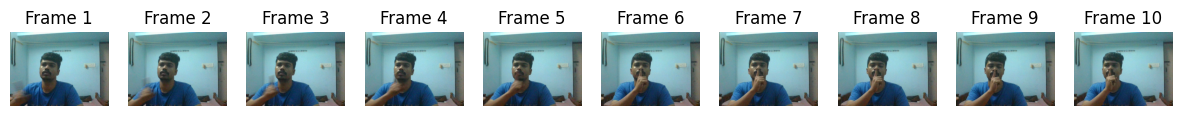

In [65]:
import matplotlib.pyplot as plt

# Convert OpenCV (BGR) frames to RGB for correct color display

rgb_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in frames]

# Show all captured frames
plt.figure(figsize=(15, 5))
for idx, img in enumerate(rgb_frames):
    plt.subplot(1, len(rgb_frames), idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Frame {idx + 1}")

plt.show()


In [66]:

pq_file = "../asl-signs/train_landmark_files/16069/10042041.parquet"
xyz_template = pd.read_parquet(pq_file)

landmarks_all = []
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:

    for idx, frame in enumerate(frames):
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(image)
        landmarks = create_frame_landmark_df(results, frame=idx, xyz_template=xyz_template)
        landmarks_all.append(landmarks)

landmarks_df = pd.concat(landmarks_all).reset_index(drop=True)
print("Landmarks extracted for all frames.")
landmarks_df.head()


I0000 00:00:1762711502.068991   57712 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1762711502.070452   72875 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.7-0ubuntu0.24.04.2), renderer: AMD Radeon Graphics (radeonsi, renoir, ACO, DRM 3.61, 6.14.0-35-generic)
W0000 00:00:1762711502.128983   72861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762711502.163312   72864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762711502.165125   72869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762711502.165119   72871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. D

Landmarks extracted for all frames.


,type,landmark_index,x,y,z,frame
0,face,0,0.368098,0.539708,-0.029238,0
1,face,1,0.371006,0.495923,-0.041891,0
2,face,2,0.371415,0.513541,-0.025389,0
3,face,3,0.369783,0.465822,-0.024921,0
4,face,4,0.372076,0.484784,-0.042998,0


In [67]:
landmarks_df.to_parquet("output.parquet")
print("Saved all frame landmarks to output.parquet")


Saved all frame landmarks to output.parquet


In [68]:
import tensorflow as tf

# Load model

interpreter = tf.lite.Interpreter(model_path="../models/model.tflite")
prediction_fn = interpreter.get_signature_runner("serving_default")

# Load training labels

train = pd.read_csv("../asl-signs/train.csv")
train['sign_ord'] = train['sign'].astype('category').cat.codes
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

# Helper function to load parquet subset

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Load and predict

xyz_np = load_relevant_data_subset("output.parquet")
prediction = prediction_fn(inputs=xyz_np)
pred_sign = ORD2SIGN[prediction["outputs"].argmax()]

print("Predicted Sign:", pred_sign)


Predicted Sign: shhh
